# Code setup

In [1]:
try:
    %load_ext lab_black
except ModuleNotFoundError:
    print("Couldn't load Black autoformatter.")

In [2]:
# To suppress warning output
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# Important imports
import numpy as np
from numpy import random
import pandas as pd
import os, sys
import math

# Set random seed across notebook for repeatable results
np.random.seed(1922)  # for Papa

In [3]:
# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

matplotlib.rcParams["font.family"] = ["sans-serif"]
matplotlib.rcParams["font.sans-serif"] = [
    "Source Sans 3",
    "Helvetica",
    "Arial",
    "sans-serif",
]
plt.rcParams["axes.titlesize"] = "x-large"  # 16
plt.rcParams["axes.labelsize"] = "x-large"
plt.rcParams["xtick.labelsize"] = "x-large"
plt.rcParams["ytick.labelsize"] = "x-large"

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "figs"

if not (os.path.isdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)):
    print("Figure directory did not exist, creating now.")
    os.mkdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)
else:
    print("Figure directory exists.")

Figure directory exists.


In [5]:
# Import classes and functions used across multiple notebooks
sys.path.append(os.getcwd())
import importlib
import functions as blt

importlib.reload(blt)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
Figure directory exists.
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
Figure directory exists.


<module 'functions' from '/Users/blt/Documents/ml-weight-fraction/functions.py'>

# Data

In [6]:
# Source (bulk organics) data

# Read in organics CP feature data
X = pd.read_csv(
    "./data/organics-preprocessed-feats.csv", sep="\t", header="infer", index_col=0
)
# Read in organics CP labels (maximum_weight_fraction)
y = pd.read_csv(
    "./data/organics-preprocessed-WF.csv", sep="\t", header="infer", index_col=0
)
y.index = X.index
print("X shape:", X.shape)
print("y shape:", y.shape)

# Read in previous hyperparameterization results
results_prelim = pd.read_csv("./data/results-prelim-organics.csv", sep="\t")
# results_final_organics = pd.read_csv(
#    "./data/results-organics.csv", sep="\t", na_values="nan", index_col=0
# )

X shape: (16439, 53)
y shape: (16439, 1)


## Apply WF bins

Labels (continuous WF data) will be binned into low (0.00-0.01), medium (0.01-0.10) and high (0.10-1.00) categories.

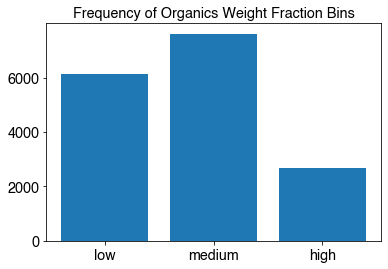

Label bin:  [0 1 2]
Count    :  [6127 7617 2695]
Frequency:  [0.37, 0.46, 0.16]


In [7]:
# Apply bins to organics data
ybin = np.asarray(y.apply(blt.bins, axis=1))

# View bar plot of WF bins
blt.bar_graph_bins(ybin, data_composition="Organics")

## Split data

In [8]:
# Split training data into training and test data (to be set aside)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, ybin, test_size=4110, random_state=1922, stratify=ybin
)
print([X_train.shape, X_test.shape])
print([y_train.shape, y_test.shape])

[(12329, 53), (4110, 53)]
[(12329,), (4110,)]


In [9]:
# Set aside "source" data

X_train, X_source, y_train, y_source = train_test_split(
    X_train, y_train, train_size=100, random_state=1922, stratify=y_train
)
print([X_train.shape, X_source.shape])
print([y_train.shape, y_source.shape])

[(100, 53), (12229, 53)]
[(100,), (12229,)]


## Pre-check PCA

[0.14889982 0.28028494 0.3906072  0.46773028 0.53482848 0.58620723
 0.63267835 0.6709188  0.70639119 0.73702448 0.76541578 0.79022016
 0.81352705 0.83196745 0.85003518 0.86768711 0.88352414 0.89811045
 0.91136413 0.92201624 0.93210242 0.94120239 0.9482765  0.95466935
 0.96084264 0.96598785 0.9706508  0.97501311 0.97890514 0.98237657]


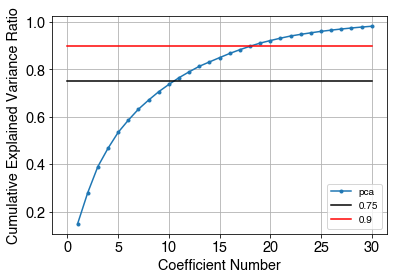

[11, 12, 13, 14, 15, 16, 17, 18]


In [10]:
component_list = blt.pca_precheck(
    X=X_source, n_components=30, thres_btm=0.75, thres_top=0.90
)

# Model optimization

In [11]:
import random as pyrandom
from numpy import random
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import MinMaxScaler

# Define feature mask for data augmentation
feat_names = X_source.columns
col_mask = ["cprp" not in name for name in feat_names]


# Function to add samples to training data


def random_augment(k, X_source, y_source, random_state, X, y):
    """Randomly samples source data to pair with target data."""

    if k == 0:
        return X, y

    pyrandom.seed(random_state)
    np.random.seed(random_state)

    # Number of samples to select
    n_samples = k * len(X)
    # Obtain indices for randomly sampling source data
    idx_match = np.random.choice(len(X_source), n_samples, replace=False)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match, :]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))
    assert (
        X_aug.shape[0] == y_aug.shape[0]
    ), f"X_aug.shape={X_aug.shape}, y_aug.shape={y_aug.shape}"

    return X_aug, y_aug


def unsupervised_augment(k, X_source, y_source, random_state, X, y):
    """
    Unsupervised data augmentation

    Match "k" most similar source data samples to target data samples
    based on the smallest cosine distance between target and source data
    samples (i.e., in an supervised fashion).
    """

    if k == 0:
        return X, y

    pyrandom.seed(random_state)
    np.random.seed(random_state)

    # Cosine distance matrix using feature mask
    cosdist_samples = cosine_distances(X_source * col_mask, X * col_mask)
    # Loop over distance matrix in search of k-smallest distances
    idx_match = []
    for col in cosdist_samples.T:
        # Find organics data indices of k-smallest distances
        matches = np.argpartition(col, k)[:k]
        idx_match.extend(matches)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match, :]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))

    return X_aug, y_aug

In [12]:
# Define models and parameters
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt

random_state = 1922
augmentation_kwargs = {
    "augmentation_random_state": random_state,
    "augmentation_X_source": X_source,
    "augmentation_y_source": y_source,
}

models = {
    "RandomForestClassifier": blt.AugmentingPipeline(
        [
            ("scaler", MinMaxScaler()),  # normalization from 0 to 1
            ("dimreducer", PCA()),
            (
                "estimator",
                RandomForestClassifier(
                    class_weight="balanced", random_state=random_state
                ),
            ),
        ],
        **augmentation_kwargs
    ),
    "SVC": blt.AugmentingPipeline(
        [
            ("scaler", MinMaxScaler()),  # normalization from 0 to 1
            ("dimreducer", PCA()),
            (
                "estimator",
                SVC(
                    kernel="rbf",
                    class_weight="balanced",  # balance by class size
                    random_state=random_state,
                ),
            ),
        ],
        **augmentation_kwargs
    ),
}
params = {
    "RandomForestClassifier": {
        "augmentation_type": [random_augment],
        "augmentation_k": [0, 1, 2, 3, 4, 9, 19, 29, 39, 49, 99],
        "dimreducer__n_components": component_list,  # [10, 11, 12, 13, 14],
        "estimator__max_depth": np.arange(2, 19, 2),
    },
    "SVC": {
        "augmentation_type": [random_augment],
        "augmentation_k": [0, 1, 2, 3, 4, 9, 19, 29, 39, 49],
        "dimreducer__n_components": component_list,
        "estimator__C": np.logspace(-1, 7, 9),
        "estimator__gamma": np.logspace(-7, 1, 9),
    },
}

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
from dask.distributed import Client
import joblib

client = Client()
helper = blt.EstimatorSelectionHelper(models, params)

with joblib.parallel_backend("dask"):
    # Apply gridsearch for optimal parameters
    helper.fit(
        X_train,
        y_train,
        n_jobs=4,
        cv=5,
        scoring="balanced_accuracy",
    )
results_prelim = helper.score_summary(sort_by="mean_score")
results_prelim.columns = [col.split("__")[-1] for col in results_prelim.columns]
results_prelim.infer_objects()

Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 792 candidates, totalling 3960 fits


[Parallel(n_jobs=4)]: Using backend DaskDistributedBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  8.2min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 12.0min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 18.0min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 26.9min
[Parallel(n_jobs=4)]: Done 3960 out of 3960 | elapsed: 39.0min finished
[Parallel(n_jobs=4)]: Using backend DaskDistributedBackend with 4 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 6480 candidates, totalling 32400 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   39.5s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed:  8.0min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done 11242 tasks      | elapsed: 12.1min
[Parallel(n_jobs=4)]: Done 12792 tasks      | elapsed: 14.7min
[Parallel(

RandomForestClassifier
SVC


,estimator,min_score,mean_score,max_score,std_score,augmentation_k,augmentation_type,n_components,max_depth,C,gamma
769,RandomForestClassifier,0.546296,0.732487,0.925926,0.121673,99,<function random_augment at 0x7f6056a8ed40>,16,10.0,NaN,NaN
724,RandomForestClassifier,0.546296,0.732487,0.888889,0.111680,99,<function random_augment at 0x7f6056a8ed40>,11,10.0,NaN,NaN
742,RandomForestClassifier,0.509259,0.731746,0.925926,0.135757,99,<function random_augment at 0x7f6056a8ed40>,13,10.0,NaN,NaN
778,RandomForestClassifier,0.509259,0.731746,0.888889,0.124932,99,<function random_augment at 0x7f6056a8ed40>,17,10.0,NaN,NaN
751,RandomForestClassifier,0.504630,0.731561,0.888889,0.125266,99,<function random_augment at 0x7f6056a8ed40>,14,10.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3222,SVC,0.319444,0.330556,0.333333,0.005556,3,<function random_augment at 0x7f6056a8ed40>,17,NaN,0.1,1.000000e-07
3227,SVC,0.319444,0.330556,0.333333,0.005556,3,<function random_augment at 0x7f6056a8ed40>,17,NaN,0.1,1.000000e-02
2096,SVC,0.296296,0.325926,0.333333,0.014815,2,<function random_augment at 0x7f6056a8ed40>,11,NaN,0.1,1.000000e+01
2177,SVC,0.296296,0.325926,0.333333,0.014815,2,<function random_augment at 0x7f6056a8ed40>,12,NaN,0.1,1.000000e+01


In [14]:
# Export preliminary results table to .csv
results_prelim.to_csv(
    "./data/results-prelim-organics.csv",
    sep="\t",
    header="infer",
    na_rep="NaN",
    index=False,
)

# Model evaluation

In [13]:
def eval_blindtest(
    df_params,
    random_state=1922,
    X=X_train,
    y=y_train,
    X_test=X_test,
    y_test=y_test,
    show_conf_matrix=True,
):
    """
    Apply hyperparameters for model evaluation.
    """

    from sklearn.decomposition import PCA
    from sklearn.metrics import confusion_matrix

    pyrandom.seed(random_state)
    np.random.seed(random_state)
    X = np.array(X)
    n_b = len(np.unique(y))  # Check number of bins

    # Select for highest performing parameters (averaged across 5 folds);
    # note that these are sorted by best mean score
    df_params["augmentation_type"] = [
        str(i).split(" ")[1] for i in df_params.loc[:, "augmentation_type"]
    ]
    feat_subset = ["estimator", "augmentation_k", "augmentation_type"]
    df_params = df_params.drop_duplicates(subset=feat_subset, keep="first")
    df_params = df_params.sort_values(by=feat_subset, ascending=[False, True, True])
    df_params.columns = [col.split("__")[-1] for col in df_params.columns]
    df_params = df_params.reset_index(drop=True)

    # Placeholder list for output
    df_params["score"] = np.nan
    df_params["score"] = df_params["score"].astype(object)

    for row in df_params.index:
        # Dictionary of classifier parameters, dropping nans
        cls_kwargs = df_params.iloc[row, -4:-1].dropna().to_dict()
        print(cls_kwargs)
        # Classifier function using dict
        if df_params.loc[row, "estimator"] == "SVC":
            classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
        else:
            classifier = RandomForestClassifier(class_weight="balanced", **cls_kwargs)
        # Define feature reducer
        pca = PCA(n_components=df_params.n_components[row], copy=True)
        print("n_components:", df_params.n_components[row])
        # Make sure augmentation_type is a function
        augmentation_type = df_params.augmentation_type[row]
        dispatcher = {
            "random_augment": random_augment,
        }
        if isinstance(augmentation_type, str):
            augmentation_type = dispatcher[augmentation_type]
        # Name figures using concatenated strings
        save_fig_name = "_".join(map(str, list(df_params.loc[row, feat_subset])))

        # Make parameter dicts
        augmentation_kwargs = {
            "augmentation_X_source": X_source,
            "augmentation_y_source": y_source,
            "augmentation_type": augmentation_type,
            "augmentation_k": df_params.augmentation_k[row],
        }

        # Pipeline with data augmentation
        pipe = blt.AugmentingPipeline(
            [
                ("scaler", MinMaxScaler()),
                ("dimreducer", pca),
                ("estimator", classifier.set_params(random_state=random_state)),
            ],
            **augmentation_kwargs
        )
        pipe.fit(X, y)

        # Write prediction results to confusion matrix
        conf_matrix = np.zeros([n_b, n_b])
        conf_matrix = confusion_matrix(y_test, pipe.predict(X_test), normalize="true")

        # Plot normalized confusion matrix
        fig = plt.figure()
        blt.plot_conf_matrix(conf_matrix, classes=["low", "mid", "high"])
        if not show_conf_matrix:
            plt.close(fig)

        # Get balanced average proportion of correct classifications
        df_params.score[row] = conf_matrix.diagonal().mean()

    cols_report = ["estimator", "augmentation_type", "augmentation_k", "score"]

    return df_params[cols_report]

## SVC-RBF

{'C': 1000000.0, 'gamma': 0.001}
n_components: 11
{'C': 10000000.0, 'gamma': 0.0001}
n_components: 18
{'C': 10.0, 'gamma': 0.01}
n_components: 18
{'C': 1000.0, 'gamma': 1e-05}
n_components: 18
{'C': 10000000.0, 'gamma': 1e-05}
n_components: 18
{'C': 1000000.0, 'gamma': 0.0001}
n_components: 18
{'C': 10000000.0, 'gamma': 0.001}
n_components: 16
{'C': 1000000.0, 'gamma': 0.001}
n_components: 16
{'C': 1000000.0, 'gamma': 0.001}
n_components: 16
{'C': 10.0, 'gamma': 0.1}
n_components: 18
{'C': 100.0, 'gamma': 10.0}
n_components: 18


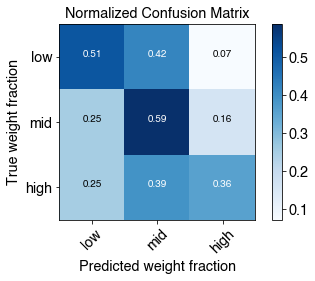

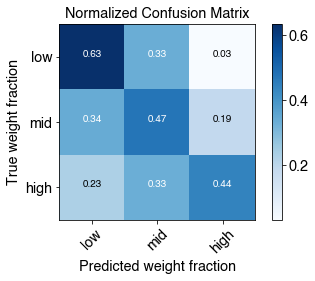

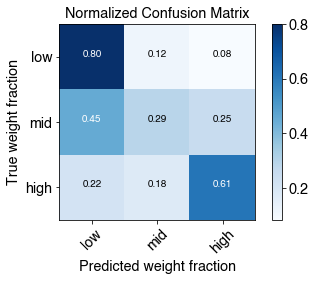

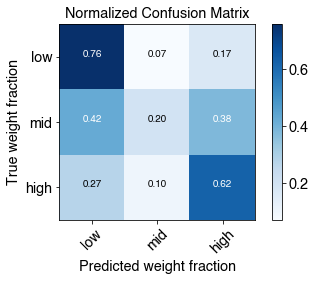

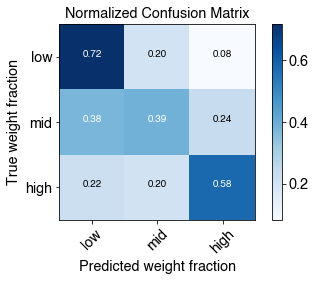

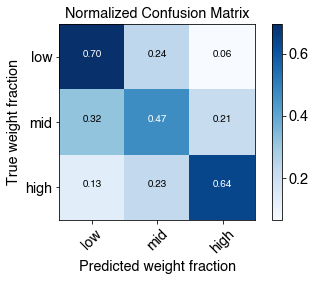

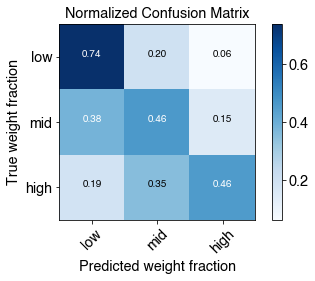

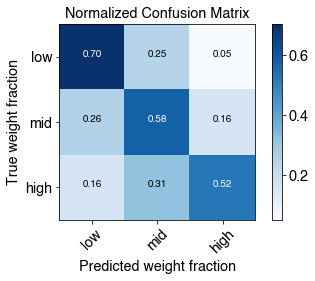

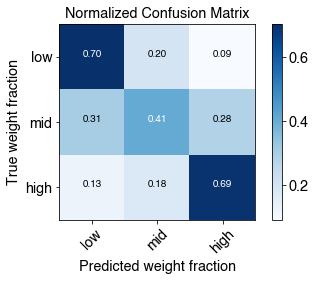

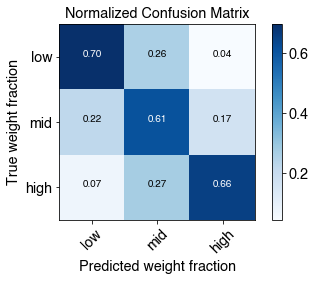

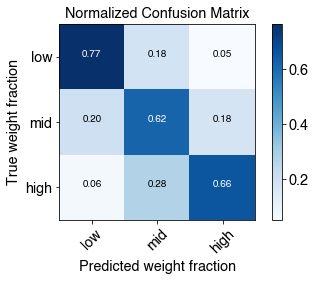

In [14]:
# SVC
results_svc = eval_blindtest(
    results_prelim[results_prelim["estimator"] == "SVC"].astype(object)
)

## RFC

{'max_depth': 6.0}
n_components: 14
{'max_depth': 2.0}
n_components: 17
{'max_depth': 8.0}
n_components: 18
{'max_depth': 2.0}
n_components: 18
{'max_depth': 8.0}
n_components: 11
{'max_depth': 10.0}
n_components: 11
{'max_depth': 10.0}
n_components: 11
{'max_depth': 18.0}
n_components: 11
{'max_depth': 14.0}
n_components: 15
{'max_depth': 10.0}
n_components: 11
{'max_depth': 10.0}
n_components: 13


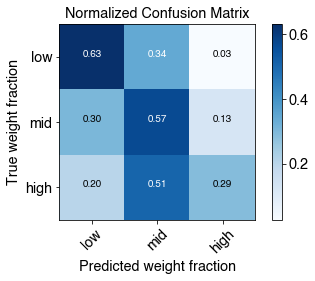

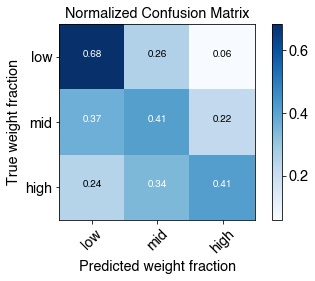

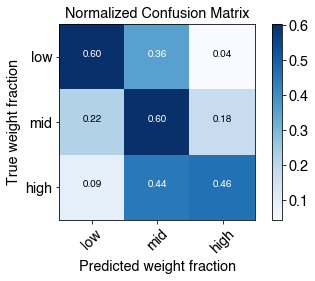

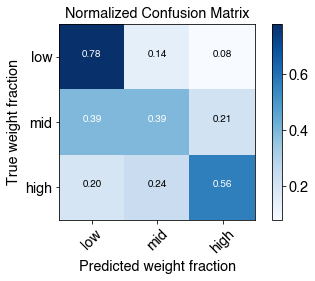

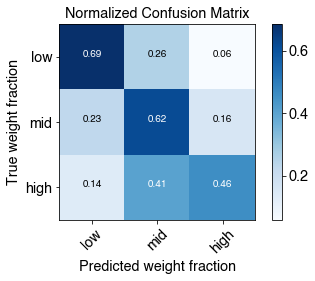

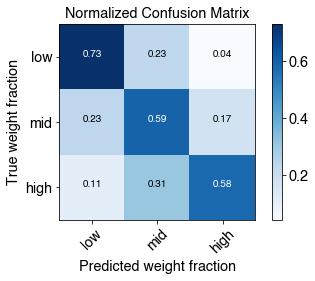

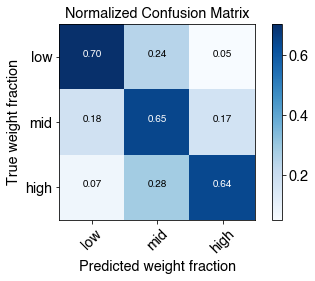

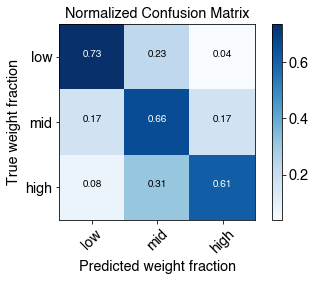

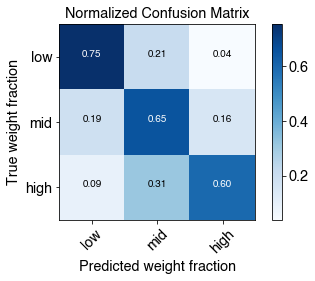

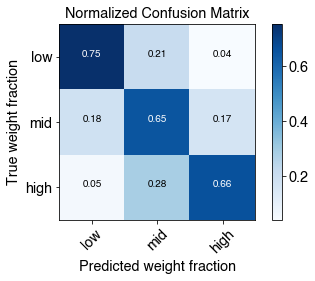

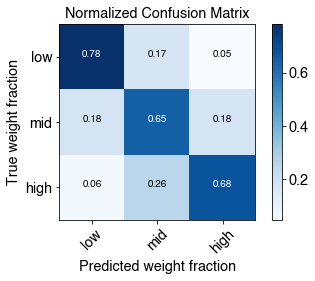

In [15]:
# RFC
results_rfc = eval_blindtest(
    results_prelim[results_prelim["estimator"] == "RandomForestClassifier"]
)

# Performance results

In [62]:
def display_table(df, df2=None):
    """Redisplay results as table for publication."""

    if isinstance(df2, pd.DataFrame):
        df = pd.concat([df, df2])

    # Tidy up labels, decimal places
    df.rename(columns={"augmentation_k": "k"}, inplace=True)
    df["estimator"] = df["estimator"].str.replace("RandomForestClassifier", "RFC")
    pd.set_option("display.precision", 3)

    # Include column for number of training samples
    n = X_train.shape[0]
    df["Training Samples"] = df["k"] * n + n

    # Pivot table
    table = df.pivot(index=["Training Samples"], columns="estimator", values="score",)
    table.columns = ["RFC", "SVC"]

    return table

In [63]:
results_final_organics = display_table(results_svc, results_rfc)
results_final_organics

,RFC,SVC
Training Samples,,
100,0.497,0.485
200,0.502,0.516
300,0.556,0.567
400,0.579,0.527
500,0.587,0.56
1000,0.635,0.602
2000,0.665,0.554
3000,0.668,0.602
4000,0.669,0.603


In [64]:
def line_plot(df, save_fig_name=None):

    myplot = df["RFC"].plot(kind="line", color="navy", marker="^")
    df["SVC"].plot(kind="line", color="royalblue", marker="o")
    plt.title("Performance of Classification Models", pad=10)
    plt.xlabel("Number of Training Samples")
    plt.ylabel("Average Balanced Accuracy")
    plt.gca().legend(loc="right", ncol=1)
    plt.xscale("log")
    if save_fig_name:
        fig = myplot.get_figure()
        blt.savepdf(fig, save_fig_name)

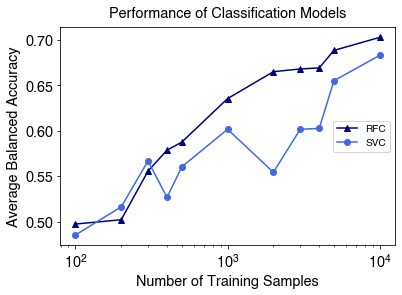

In [65]:
line_plot(df=results_final_organics, save_fig_name="bal-accu-plot-organics")

In [66]:
# Export results table to .csv
results_final_organics.to_csv(
    "./data/results-organics.csv", sep="\t", header="infer", na_rep="NaN",
)

# Export results table as a LaTeX-compatible file
results_final_organics.to_latex()

'\\begin{tabular}{lll}\n\\toprule\n{} &    RFC &    SVC \\\\\nTraining Samples &        &        \\\\\n\\midrule\n100              &  0.497 &  0.485 \\\\\n200              &  0.502 &  0.516 \\\\\n300              &  0.556 &  0.567 \\\\\n400              &  0.579 &  0.527 \\\\\n500              &  0.587 &   0.56 \\\\\n1000             &  0.635 &  0.602 \\\\\n2000             &  0.665 &  0.554 \\\\\n3000             &  0.668 &  0.602 \\\\\n4000             &  0.669 &  0.603 \\\\\n5000             &  0.688 &  0.655 \\\\\n10000            &  0.703 &  0.683 \\\\\n\\bottomrule\n\\end{tabular}\n'

# Feature comparison

In [ ]:
from dask.distributed import Client
import joblib

client = Client()

In [82]:
# Select 1000 data samples for training

X_train, _, y_train, _ = train_test_split(
    X_source, y_source, train_size=1000, random_state=1922, stratify=y_source
)
print([X_train.shape, y_train.shape])

[(1000, 53), (1000,)]


In [87]:
def feat_comparison(list_col_idx, X_train=X_train, X_test=X_test):
    """Run hyperparameterization and model evaluation for a subset of features"""

    # Select subset of features
    X_train = X_train.iloc[:, list_col_idx]
    X_test = X_test.iloc[:, list_col_idx]

    # Find range of PCA components to test during hyperparameterization
    components = blt.pca_precheck(
        X=X_train, n_components=len(list_col_idx), thres_btm=0.75, thres_top=0.9
    )

    # Define models and parameters; no data augmentation is applied
    random_state = 1922
    augmentation_kwargs = {
        "augmentation_random_state": random_state,
        "augmentation_X_source": X_source,
        "augmentation_y_source": y_source,
    }
    models = {
        "RandomForestClassifier": blt.AugmentingPipeline(
            [
                ("scaler", MinMaxScaler()),  # normalization from 0 to 1
                ("dimreducer", PCA()),
                (
                    "estimator",
                    RandomForestClassifier(
                        class_weight="balanced", random_state=random_state
                    ),
                ),
            ],
            **augmentation_kwargs
        ),
        "SVC": blt.AugmentingPipeline(
            [
                ("scaler", MinMaxScaler()),  # normalization from 0 to 1
                ("dimreducer", PCA()),
                (
                    "estimator",
                    SVC(
                        kernel="rbf",
                        class_weight="balanced",  # balance by class size
                        random_state=random_state,
                    ),
                ),
            ],
            **augmentation_kwargs
        ),
    }
    params = {
        "RandomForestClassifier": {
            "augmentation_type": [random_augment],
            "augmentation_k": [0],
            "dimreducer__n_components": components,
            "estimator__max_depth": np.arange(2, 19, 2),
        },
        "SVC": {
            "augmentation_type": [random_augment],
            "augmentation_k": [0],
            "dimreducer__n_components": components,
            "estimator__C": np.logspace(-1, 7, 9),
            "estimator__gamma": np.logspace(-7, 1, 9),
        },
    }

    # Hyperparameterization
    helper = blt.EstimatorSelectionHelper(models, params)
    # with joblib.parallel_backend("dask"):
    # Apply gridsearch for optimal parameters
    helper.fit(
        X_train,
        y_train,
        n_jobs=1,
        cv=5,
        scoring="balanced_accuracy",  # TODO: n_jobs=4 with dask
    )
    res_prelim = helper.score_summary(sort_by="mean_score")
    res_prelim.columns = [col.split("__")[-1] for col in res_prelim.columns]
    res_prelim.infer_objects()

    # Model evaluation
    res_rfc = eval_blindtest(
        df_params=res_prelim[
            res_prelim["estimator"] == "RandomForestClassifier"
        ].astype(object),
        X=X_train,
        y=y_train,
        X_test=X_test,
    )
    res_svc = eval_blindtest(
        df_params=res_prelim[res_prelim["estimator"] == "SVC"].astype(object),
        X=X_train,
        y=y_train,
        X_test=X_test,
    )
    res_all = pd.concat([res_rfc, res_svc]).pivot(columns=["estimator"]).iloc[:, -2:]
    res_all.columns = ["RFC", "SVC"]

    return res_all

In [88]:
# Get column indices for groups of features
# Feature groups: chemical properties, functional uses,
# product categories, matrix properties, WF_measured
feat_names = X_train.columns
idx_cprponly = [i for i, s in enumerate(feat_names) if "cprp" in s]
idx_funconly = [i for i, s in enumerate(feat_names) if "func" in s]
idx_pcatonly = [i for i, s in enumerate(feat_names) if "pgen" in s]
idx_pcatonly += [i for i, s in enumerate(feat_names) if "pgrp" in s]
idx_mtrxonly = [i for i, s in enumerate(feat_names) if "mtrx" in s]
del idx_mtrxonly[-1]  # do not include mtrx_WFmeasured

print("Chemical property column indices", idx_cprponly)
print("Functional use column indices\t", idx_funconly)
print("Matrix property column indices\t", idx_mtrxonly)
print("Was WF measured? index\t\t", [-1])
print("Product category column indices\t", idx_pcatonly)

Chemical property column indices [0, 1, 2, 3]
Functional use column indices	 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Matrix property column indices	 [50, 51]
Was WF measured? index		 [-1]
Product category column indices	 [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


[0.8  0.92 0.97 1.  ]


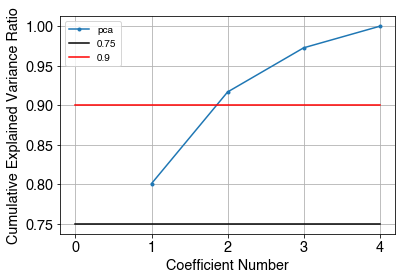

[1]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 31.4min finished


RandomForestClassifier
SVC
{'max_depth': 14}
n_components: 1
{'C': 10000.0, 'gamma': 0.1}
n_components: 1
[0.23 0.41 0.55 0.66 0.74 0.8  0.86 0.9  0.93 0.95 0.97 0.98 0.99 0.99
 1.   1.  ]


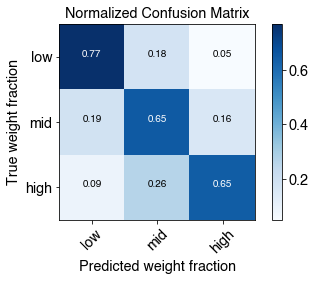

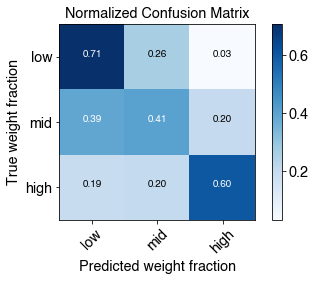

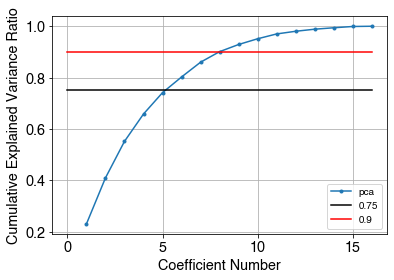

[6, 7]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   13.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:  8.5min finished


RandomForestClassifier
SVC
{'max_depth': 6}
n_components: 7
{'C': 1.0, 'gamma': 1.0}
n_components: 7
[0.34 0.48 0.59 0.66 0.72 0.77 0.81 0.84 0.87 0.9  0.92 0.94 0.96 0.97
 0.98 0.99 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.  ]


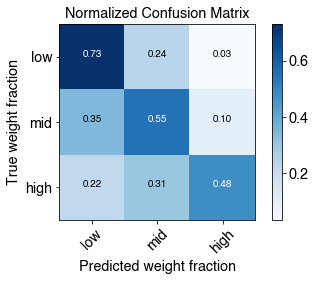

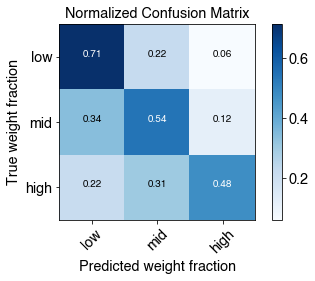

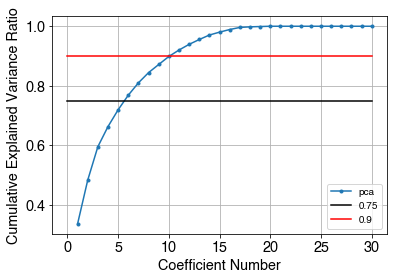

[6, 7, 8, 9, 10]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   37.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=1)]: Done 2025 out of 2025 | elapsed:  4.4min finished


RandomForestClassifier
SVC
{'max_depth': 4}
n_components: 7
{'C': 10000.0, 'gamma': 10.0}
n_components: 6
[1. 1.]


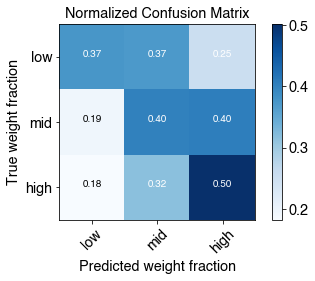

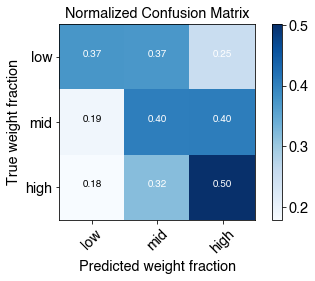

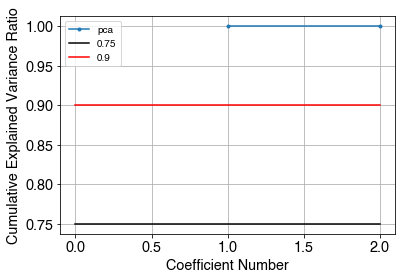

[1]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:   11.1s finished


RandomForestClassifier
SVC
{'max_depth': 2}
n_components: 1
{'C': 0.1, 'gamma': 1.0}
n_components: 1
[0.22 0.39 0.53 0.63 0.71 0.77 0.82 0.87 0.9  0.92 0.94 0.96 0.97 0.98
 0.99 0.99 1.   1.   1.   1.  ]


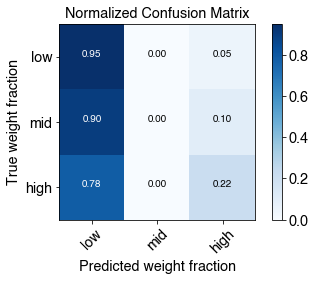

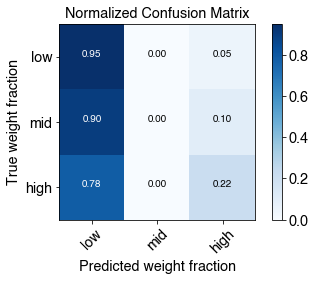

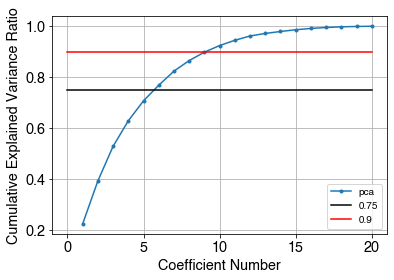

[6, 7, 8, 9]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   34.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed: 52.8min finished


RandomForestClassifier
SVC
{'max_depth': 8}
n_components: 7
{'C': 1000000.0, 'gamma': 1.0}
n_components: 6
[0.22 0.39 0.53 0.63 0.71 0.77 0.82 0.87 0.9  0.92 0.94 0.96 0.97 0.98
 0.99 0.99 1.   1.   1.   1.   1.  ]


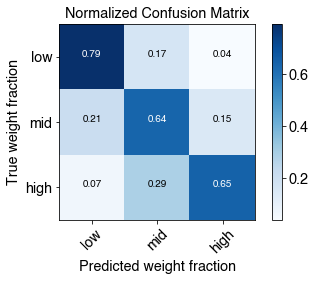

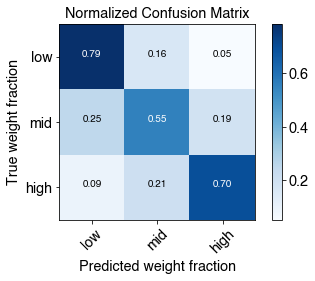

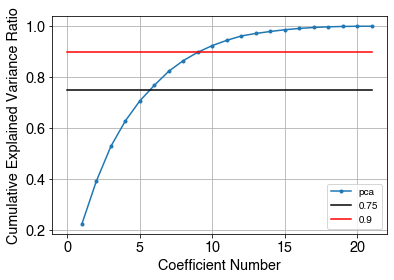

[6, 7, 8, 9]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   35.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed: 54.7min finished


RandomForestClassifier
SVC
{'max_depth': 8}
n_components: 7
{'C': 1000000.0, 'gamma': 1.0}
n_components: 6
[0.21 0.37 0.51 0.6  0.68 0.73 0.79 0.84 0.88 0.9  0.93 0.95 0.96 0.97
 0.98 0.99 0.99 1.   1.   1.   1.   1.   1.  ]


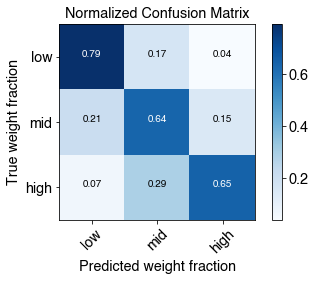

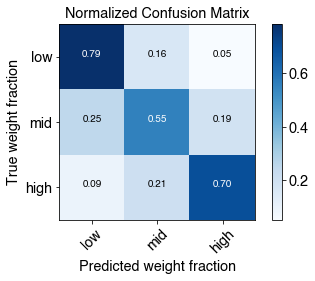

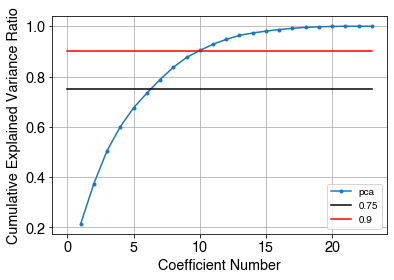

[7, 8, 9]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   27.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed: 36.7min finished


RandomForestClassifier
SVC
{'max_depth': 8}
n_components: 7
{'C': 1000000.0, 'gamma': 1.0}
n_components: 8
[0.15 0.28 0.39 0.46 0.53 0.58 0.63 0.67 0.71 0.74 0.77 0.79 0.82 0.83
 0.85 0.87 0.88 0.9  0.91 0.92 0.93 0.94 0.95 0.95 0.96 0.96 0.97 0.97
 0.98 0.98 0.99 0.99 0.99 0.99 1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  ]


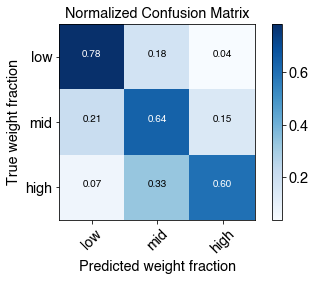

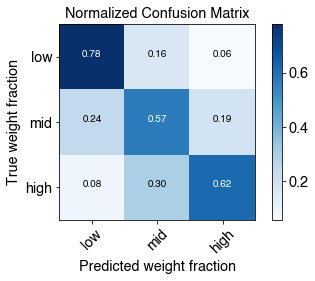

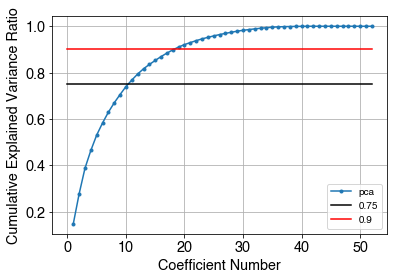

[11, 12, 13, 14, 15, 16, 17, 18]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=1)]: Done 3240 out of 3240 | elapsed: 56.4min finished


RandomForestClassifier
SVC
{'max_depth': 8}
n_components: 16
{'C': 1000.0, 'gamma': 0.01}
n_components: 18
[0.15 0.28 0.39 0.46 0.53 0.58 0.63 0.67 0.71 0.74 0.77 0.79 0.82 0.83
 0.85 0.87 0.88 0.9  0.91 0.92 0.93 0.94 0.95 0.95 0.96 0.96 0.97 0.97
 0.98 0.98 0.99 0.99 0.99 0.99 1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  ]


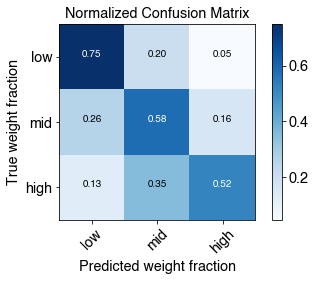

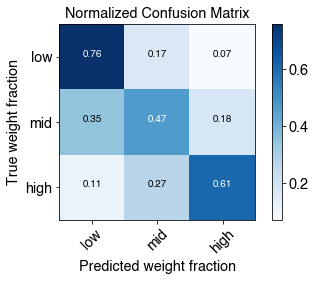

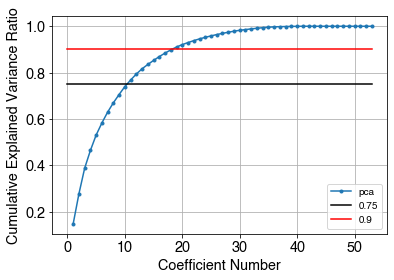

[11, 12, 13, 14, 15, 16, 17, 18]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 92.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=1)]: Done 3240 out of 3240 | elapsed: 57.5min finished


RandomForestClassifier
SVC
{'max_depth': 6}
n_components: 15
{'C': 1000.0, 'gamma': 0.01}
n_components: 18


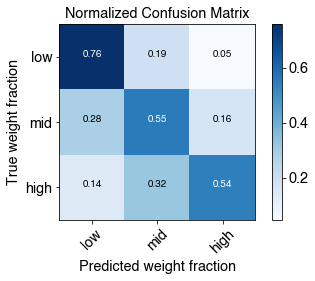

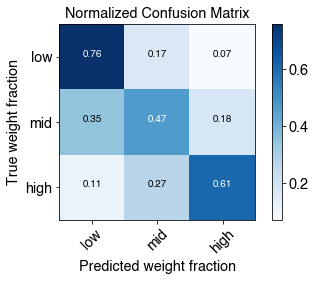

In [89]:
# Run feature comparisons

# List of lists of feature indices to try
list_idx_list = [
    idx_cprponly,
    idx_funconly,
    idx_pcatonly,
    idx_mtrxonly,
    idx_cprponly + idx_funconly,
    idx_cprponly + idx_funconly + [-1],
    idx_cprponly + idx_funconly + idx_mtrxonly + [-1],
    idx_cprponly + idx_funconly + idx_pcatonly + idx_mtrxonly,
    idx_cprponly + idx_funconly + idx_pcatonly + idx_mtrxonly + [-1],
]

res = pd.DataFrame(columns=["RFC", "SVC"])
for l in list_idx_list:
    res_row = feat_comparison(l)
    res = res.append(res_row, ignore_index=True)

In [90]:
res

,RFC,SVC
0,0.689,0.572
1,0.587,0.578
2,0.426,0.426
3,0.389,0.389
4,0.693,0.68
5,0.693,0.68
6,0.674,0.655
7,0.618,0.616
8,0.617,0.616


In [91]:
feat_table = pd.DataFrame(
    {
        "chemical properties": ["X", "", "", "", "X", "X", "X", "X", "X"],
        "functional uses": ["", "X", "", "", "X", "X", "X", "X", "X"],
        "product categories": ["", "", "X", "", "", "", "", "X", "X"],
        "matrix properties": ["", "", "", "X", "", "", "X", "X", "X"],
        "WF measured?": ["", "", "", "", "", "X", "X", "", "X"],
    }
)
feat_compare = pd.concat([feat_table, res], axis=1)
feat_compare

,chemical properties,functional uses,product categories,matrix properties,WF measured?,RFC,SVC
0,X,,,,,0.689,0.572
1,,X,,,,0.587,0.578
2,,,X,,,0.426,0.426
3,,,,X,,0.389,0.389
4,X,X,,,,0.693,0.68
5,X,X,,,X,0.693,0.68
6,X,X,,X,X,0.674,0.655
7,X,X,X,X,,0.618,0.616
8,X,X,X,X,X,0.617,0.616


In [93]:
feat_compare.to_latex(buf='data/results-feat-compare-organics.txt', 
                       float_format="%.3f", index_names=False)

TypeError: 'str' object is not callable